### Outlier Detection using autoencoders-First version
### Using  the whole data
#### Edgar Acuna
#### February 2022
#### Dataset: Diabetes

In [36]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
url= "https://academic.uprm.edu/eacuna/diabetes.dat"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
data = pd.read_table(url, names=names)
yd=data['class']
Xd=data.iloc[:,0:8]

In [38]:
from sklearn.preprocessing import  StandardScaler
cols_to_norm = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age']
scaler = MinMaxScaler()
data[cols_to_norm] = scaler.fit_transform(data[cols_to_norm])
data.shape

(768, 9)

In [39]:
train_x = data.drop(['class'], axis=1) #drop the class column
train_x.info()
train_x = train_x.values #transform to ndarray
train_x

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    768 non-null    float64
 1   plas    768 non-null    float64
 2   pres    768 non-null    float64
 3   skin    768 non-null    float64
 4   test    768 non-null    float64
 5   mass    768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    float64
dtypes: float64(8)
memory usage: 48.1 KB


array([[0.35294118, 0.74371859, 0.59016393, ..., 0.50074516, 0.23441503,
        0.48333333],
       [0.05882353, 0.42713568, 0.54098361, ..., 0.39642325, 0.11656704,
        0.16666667],
       [0.47058824, 0.91959799, 0.52459016, ..., 0.34724292, 0.25362938,
        0.18333333],
       ...,
       [0.29411765, 0.6080402 , 0.59016393, ..., 0.390462  , 0.07130658,
        0.15      ],
       [0.05882353, 0.63316583, 0.49180328, ..., 0.4485842 , 0.11571307,
        0.43333333],
       [0.05882353, 0.46733668, 0.57377049, ..., 0.45305514, 0.10119556,
        0.03333333]])

In [40]:
# No of Neurons in each Layer 
nb_epoch = 20
batch_size = 50
input_dim = train_x.shape[1] #num of columns, 8
encoding_dim = 4
hidden_dim = int(encoding_dim / 2) #i.e. 7
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 24        
Total params: 76
Trainable params: 76
Non-trainable params: 0
_________________________________________________________________


In [41]:
import datetime
autoencoder.compile(optimizer='adam', loss='mse' )

t_ini = datetime.datetime.now()
history = autoencoder.fit(train_x, train_x,
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.1,
                        verbose=0
                        )

t_fin = datetime.datetime.now()
print('Time to run the model: {} Sec.'.format((t_fin - 
t_ini).total_seconds()))



df_history = pd.DataFrame(history.history) 

Time to run the model: 0.742536 Sec.


In [42]:
#Reconstruction
predictions = autoencoder.predict(train_x)
print(predictions)
train_x.shape

[[0.24737273 0.         0.         ... 0.4776856  0.13946944 0.25934017]
 [0.19589132 0.         0.         ... 0.41233617 0.16907308 0.1735572 ]
 [0.2418936  0.         0.         ... 0.4823538  0.17277786 0.21641311]
 ...
 [0.23620382 0.         0.         ... 0.46892348 0.15994284 0.22498296]
 [0.19366518 0.         0.         ... 0.38584948 0.1089628  0.23864691]
 [0.2009036  0.         0.         ... 0.4294478  0.19408035 0.1506538 ]]


(768, 8)

In [43]:
mse = np.mean(np.power(train_x- predictions, 2), axis=1)
df_error = pd.DataFrame({'reconstruction_error': mse, 'Label': yd}, index=yd.index)
df_error.describe()

,reconstruction_error,Label
count,768.000000,768.000000
mean,0.108202,1.348958
std,0.040596,0.476951
min,0.021335,1.000000
25%,0.078995,1.000000
50%,0.100210,1.000000
75%,0.131833,2.000000
max,0.303772,2.000000


In [44]:
dfOutliers = df_error.index[df_error.reconstruction_error > .15].tolist()
len(dfOutliers)

120

In [45]:
print(dfOutliers)

[2, 8, 9, 11, 12, 13, 22, 24, 28, 43, 45, 53, 56, 58, 72, 84, 106, 115, 120, 123, 148, 152, 153, 154, 155, 159, 175, 177, 185, 186, 187, 206, 207, 209, 211, 212, 220, 221, 228, 236, 237, 238, 245, 247, 258, 259, 260, 283, 286, 317, 319, 323, 327, 335, 339, 355, 359, 360, 361, 362, 363, 370, 375, 399, 408, 409, 415, 425, 428, 436, 440, 445, 455, 458, 459, 487, 489, 495, 498, 506, 516, 519, 545, 546, 548, 549, 561, 579, 580, 582, 588, 595, 598, 606, 612, 622, 658, 660, 661, 662, 666, 673, 675, 676, 681, 684, 691, 695, 702, 708, 716, 728, 732, 743, 744, 746, 748, 753, 759, 761]


In [46]:
y=df_error['reconstruction_error'].tolist()
x = df_error.index.tolist()

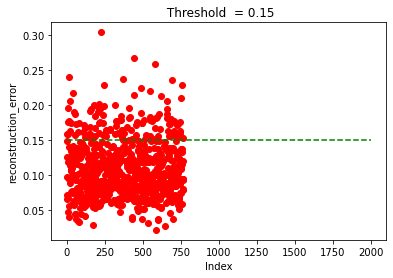

In [47]:
thresh=0.15
plt.plot(x, y, 'ro')
plt.ylabel('reconstruction_error')
plt.xlabel('Index')
plt.title(' Threshold  = ' +str(thresh))
plt.plot([0,2000],[thresh,thresh],"g--")

In [48]:
#cleaning the data from outliers
data3=data.drop(dfOutliers,axis=0)

### Outlier effect on the LDA Classifier

In [32]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
ldadis = LinearDiscriminantAnalysis().fit(Xd,yd)
scores = cross_val_score(ldadis, Xd, yd, cv=10)
print("Accuracy using LDA: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy using LDA: 0.77 (+/- 0.07)


In [49]:
#Accuracy after removing outliers
y=data3['class']
X=data3.iloc[:,0:8]
#Haciendo el analisis discriminante y calculando el porcentaje de precision
ldadis = LinearDiscriminantAnalysis().fit(X,y)
scores = cross_val_score(ldadis, X, y, cv=10)
scores
print("Accuracy using LDA after outlier removal: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy using LDA after outlier removal: 0.77 (+/- 0.08)


### Outlier effect on the KNN classifier

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
neigh = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(neigh, Xd, yd, cv=10)
scores
print("Accuracy using k=5 neighbors: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy using k=5 neighbors: 0.72 (+/- 0.09)


In [52]:
#Accuracy after remoing outliers
y=data3['class']
X=data3.iloc[:,0:8]
y1=y.to_numpy()
X1=X.to_numpy()
neigh = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(neigh, X1, y1, cv=10)
scores
print("Accuracy using k=5 neighbors after outlier removal: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy using k=5 neighbors after outlier removal: 0.75 (+/- 0.13)
